In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import datetime as date
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans

In [4]:
def format_data(dataset):
    if 'EventTime' in dataset.columns:
        dataset['EventTime'] = pd.to_datetime(dataset['EventTime'])
    if 'Class' in dataset.columns:
        dataset['Class'] = dataset['Class'].fillna('O').astype(str)
    return dataset

Training Data and Testing Data - Data Types converted

In [5]:
trainingData = format_data(pd.read_csv('training.csv'))
testingData = format_data(pd.read_csv('testing.csv'))

Data at Glance - Training and Testing

In [6]:
def sum_stats(trainSummary, testSummary):
    return "Summary Statistics:\n"\
        'Training Summary', trainSummary.describe(),\
        'Tesing Summary:', testSummary.describe()

sum_stats(trainingData, testingData)

('Summary Statistics:\nTraining Summary',
                            EventTime       Measure
 count                          25000  25000.000000
 mean   2020-11-12 16:05:16.799999744    386.876760
 min              2020-08-17 18:30:00      1.000000
 25%              2020-09-30 04:07:30    315.000000
 50%              2020-11-12 13:45:00    375.000000
 75%              2020-12-26 03:22:30    450.000000
 max              2021-02-07 19:00:00   1000.000000
 std                              NaN    104.100969,
 'Tesing Summary:',
                            EventTime      Measure
 count                           8011  8011.000000
 mean   2021-03-07 16:26:00.479341056   548.587317
 min              2021-02-07 19:10:00   165.000000
 25%              2021-02-21 17:55:00   476.000000
 50%              2021-03-07 16:30:00   554.000000
 75%              2021-03-21 15:15:00   613.000000
 max              2021-04-04 13:00:00  1104.000000
 std                              NaN    99.514687)

In [7]:
def sum_analysis(trainData, testData):
    return "DATA-TYPES:\n" \
        'Training:', trainData.dtypes, \
        'Testing:', testData.dtypes, \
    "Uniques: \n" \
        'Training:', trainData.nunique(), \
        'Testing:', testingData.nunique()
dataGlance = sum_analysis(trainingData, testingData)
dataGlance

('DATA-TYPES:\nTraining:',
 EventTime    datetime64[ns]
 Measure               int64
 Class                object
 dtype: object,
 'Testing:',
 EventTime    datetime64[ns]
 Measure               int64
 Class                object
 dtype: object,
 'Uniques: \nTraining:',
 EventTime    25000
 Measure        754
 Class            2
 dtype: int64,
 'Testing:',
 EventTime    8011
 Measure       564
 Class           2
 dtype: int64)

Graphically representing anomaly class (training, testing)

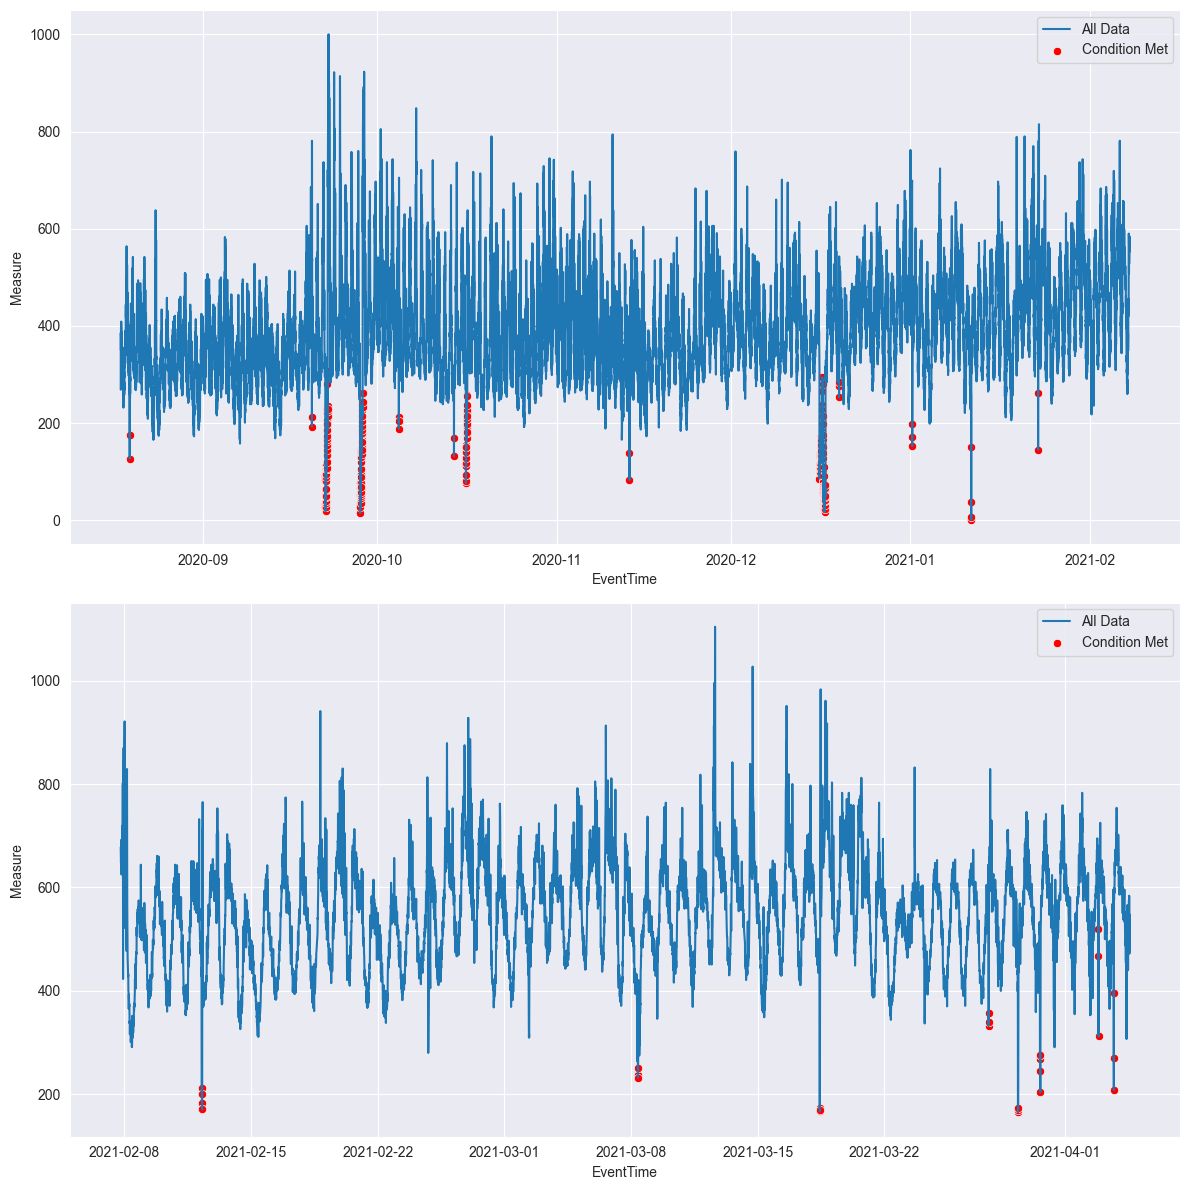

In [12]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
# Plot the entire dataset
sns.lineplot(data=trainingData, x='EventTime', y='Measure', ax=ax1, label='All Data')

# Subset Plotting
'''Training Graph'''
condition_met_data = trainingData[trainingData['Class'] == 'S']
sns.scatterplot(data=condition_met_data, x='EventTime', y='Measure', ax=ax1, label='Condition Met', color='red', markers=True)
sns.lineplot(data=testingData, x='EventTime', y='Measure', ax=ax2, label='All Data')

'''Testing Graph'''
condition_met_data2 = testingData[testingData['Class'] == 'S']
sns.scatterplot(data=condition_met_data2, x='EventTime', y='Measure', ax=ax2, label='Condition Met', color='red', markers=True)

plt.tight_layout()
plt.show()

Z - Score Calculation (Raw Datasets, with PrePros)

In [9]:

trainingArray =  np.array([i for i in trainingData.iloc[:, 1]])
trainingArray

scaler = StandardScaler()
z_scores = scaler.fit_transform(trainingArray.reshape(-1, 1))
z_scores

trainingData['z_scores'] = scaler.fit_transform(trainingData['Measure'].values.reshape(-1, 1))
trainingData

,EventTime,Measure,Class,z_scores
0,2020-08-17 18:30:00,269,O,-1.132354
1,2020-08-17 18:40:00,380,O,-0.066060
2,2020-08-17 18:50:00,386,O,-0.008422
3,2020-08-17 19:00:00,376,O,-0.104485
4,2020-08-17 19:10:00,374,O,-0.123697
...,...,...,...,...
24995,2021-02-07 18:20:00,568,O,1.739915
24996,2021-02-07 18:30:00,570,O,1.759128
24997,2021-02-07 18:40:00,564,O,1.701490
24998,2021-02-07 18:50:00,583,O,1.884009


Experimental Threshold - Z score based

Identify optimal thresholds - Z-score based (Excl. Class Measure Labels)

In [36]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
from sklearn.preprocessing import StandardScaler
# Split (Theoretical) on dataset
train_size = int(0.8 * len(trainingData))
train_data = trainingData.iloc[:train_size].copy()
val_data = trainingData.iloc[train_size:].copy()
# Create a threshold range to explore
threshold_range = np.linspace(-2.0, 5.0, num=50)  # Adjust the range as needed

# Define the scoring metric (e.g., precision)
scoring_metric = make_scorer(precision_score)

# Initialize the StandardScaler
scaler = StandardScaler()

# Define a function to evaluate the model with a given threshold
def evaluate_threshold(threshold, train_data, val_data):
    # Calculate Z-scores for the training data
    train_data['z_score'] = scaler.fit_transform(train_data['Measure'].values.reshape(-1, 1))

    # Identify anomalies using the threshold and mark as "Anomaly" or "Normal"
    train_data['is_anomaly'] = np.where(train_data['z_score'] > threshold, "Anomaly", "Normal")

    # Calculate precision on the validation data
    val_data['z_score'] = scaler.transform(val_data['Measure'].values.reshape(-1, 1))
    val_data['is_anomaly'] = np.where(val_data['z_score'] > threshold, "Anomaly", "Normal")
    # Ensure you have a corresponding label in your validation data for comparison
    precision = precision_score(val_data['is_anomaly'], val_data['is_anomaly'], pos_label="Anomaly")

    return precision



# Initialize an empty list to store precision scores
precision_scores = []

# Loop through the threshold range and calculate precision for each threshold
for threshold in threshold_range:
    precision = evaluate_threshold(threshold, train_data, val_data)
    precision_scores.append(precision)

# Find the best threshold
best_threshold = threshold_range[np.argmax(precision_scores)]
best_precision = max(precision_scores)
print(f'Best Threshold: {best_threshold}')
print(f'Best Precision: {best_precision}')

Best Threshold: -2.0
Best Precision: 1.0


C:\Users\User\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\pythonProject\lib\site-packages\skl

Simulation on varying thresholds

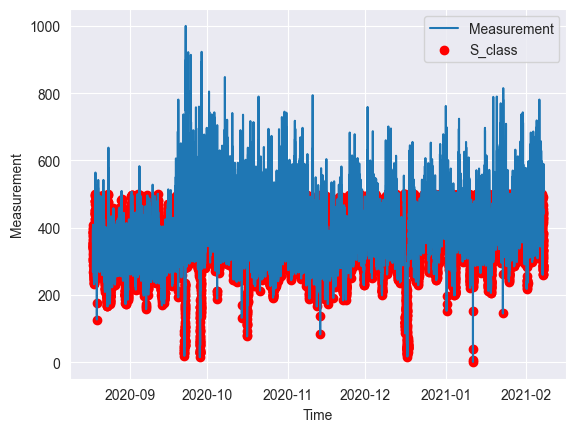

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

trainingArray =  np.array([i for i in trainingData.iloc[:, 1]])

scaler = StandardScaler()
z_scores = scaler.fit_transform(trainingArray.reshape(-1, 1))

trainingData['z_scores'] = scaler.fit_transform(trainingData['Measure'].values.reshape(-1, 1))
threshold = 1.1
trainingData['S_class'] = trainingData['z_scores'] < threshold
anomalies = z_scores > threshold


plt.plot(trainingData['EventTime'], trainingData['Measure'], label='Measurement')
plt.scatter(trainingData['EventTime'][trainingData['S_class']], trainingData['Measure'][trainingData['S_class']], c='red', label='S_class')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.show()



In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score


# Calculate Z-scores
scaler = StandardScaler()
trainingData['z_score'] = scaler.fit_transform(trainingData['Measure'].values.reshape(-1, 1))

# Set the threshold based on the best threshold found earlier
best_threshold = 1.1  # Replace with the actual best threshold value calculated

# Label anomalies based on the threshold
trainingData['is_anomaly'] = (trainingData['z_score'] > best_threshold) | (trainingData['z_score'] < -best_threshold)
trainingData

,EventTime,Measure,Class,z_scores,S_class_label,S_class,z_score,is_anomaly
0,2020-08-17 18:30:00,269,O,-1.132354,True,True,-1.132354,True
1,2020-08-17 18:40:00,380,O,-0.066060,True,True,-0.066060,False
2,2020-08-17 18:50:00,386,O,-0.008422,True,True,-0.008422,False
3,2020-08-17 19:00:00,376,O,-0.104485,True,True,-0.104485,False
4,2020-08-17 19:10:00,374,O,-0.123697,True,True,-0.123697,False
...,...,...,...,...,...,...,...,...
24995,2021-02-07 18:20:00,568,O,1.739915,False,False,1.739915,True
24996,2021-02-07 18:30:00,570,O,1.759128,False,False,1.759128,True
24997,2021-02-07 18:40:00,564,O,1.701490,False,False,1.701490,True
24998,2021-02-07 18:50:00,583,O,1.884009,False,False,1.884009,True


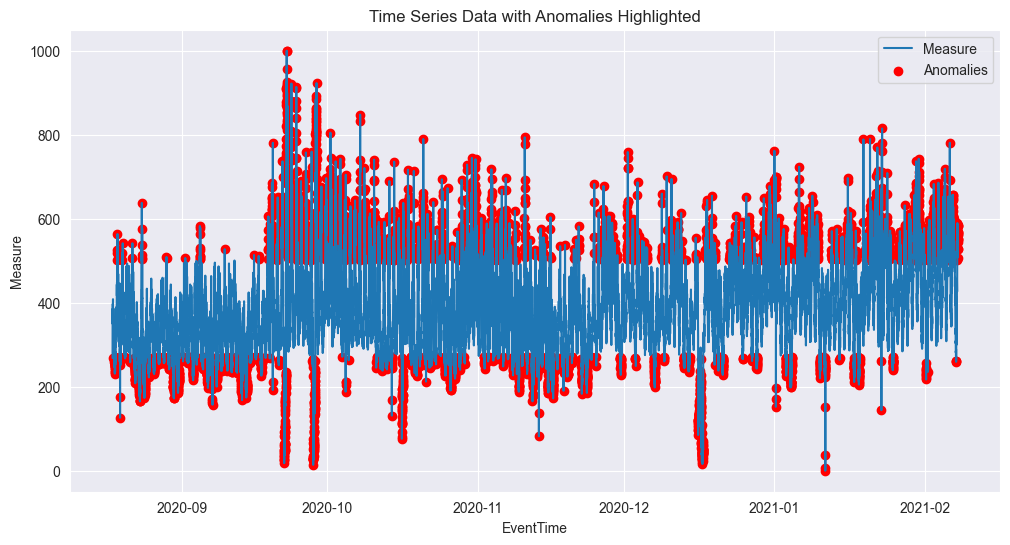

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(trainingData['EventTime'], trainingData['Measure'], label='Measure')

# Highlight anomalies
anomaly_indices = trainingData[trainingData['is_anomaly']].index
anomaly_values = trainingData[trainingData['is_anomaly']]['Measure']
plt.scatter(trainingData['EventTime'][anomaly_indices], anomaly_values, c='red', marker='o', label='Anomalies')

plt.xlabel('EventTime')
plt.ylabel('Measure')
plt.legend()
plt.title('Time Series Data with Anomalies Highlighted')
plt.grid(True)
plt.show()



Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17781
           1       1.00      1.00      1.00      8627

    accuracy                           1.00     26408
   macro avg       1.00      1.00      1.00     26408
weighted avg       1.00      1.00      1.00     26408

Confusion Matrix:
[[17781     0]
 [    0  8627]]

Testing Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4439
           1       1.00      1.00      1.00      2164

    accuracy                           1.00      6603
   macro avg       1.00      1.00      1.00      6603
weighted avg       1.00      1.00      1.00      6603

Confusion Matrix:
[[4439    0]
 [   0 2164]]


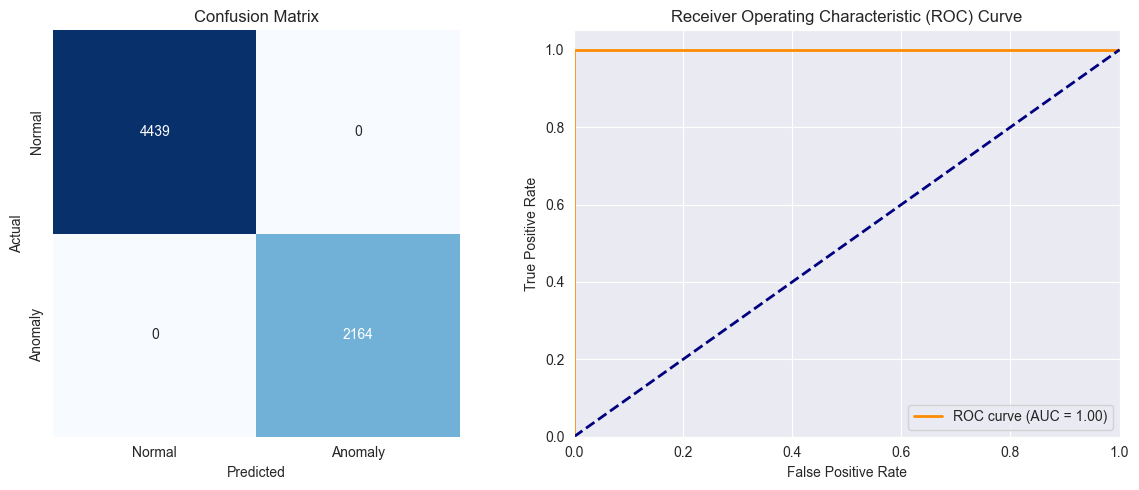

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

dataAll = pd.concat([trainingData, testingData])

# Calculate Z-scores
scaler = StandardScaler()
dataAll['z_score'] = scaler.fit_transform(dataAll['Measure'].values.reshape(-1, 1))

# Set the upper and lower threshold based on the best threshold found earlier
best_threshold = 1.0  # Replace with the actual best threshold value

# Label anomalies based on the upper and lower thresholds
dataAll['is_anomaly'] = (dataAll['z_score'] > best_threshold) | (dataAll['z_score'] < -best_threshold)

# Split the data into features and target
X = dataAll['z_score'].values.reshape(-1, 1)  # Features (Z-scores)
y = dataAll['is_anomaly'].astype(int)  # Target (0 for normal, 1 for anomaly)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier (you can use other classifiers as well)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = clf.predict(X_train)

# Evaluate the model's performance on the training data
print("Training Set Evaluation:")
print(classification_report(y_train, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred_train))

# Make predictions on the testing data
y_pred_test = clf.predict(X_test)

# Evaluate the model's performance on the testing data
print("\nTesting Set Evaluation:")
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


conf_matrix = confusion_matrix(y_test, y_pred_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

array([0, 0, 0, ..., 0, 0, 0])

Classification Metrics:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4439
     Anomaly       1.00      1.00      1.00      2164

    accuracy                           1.00      6603
   macro avg       1.00      1.00      1.00      6603
weighted avg       1.00      1.00      1.00      6603



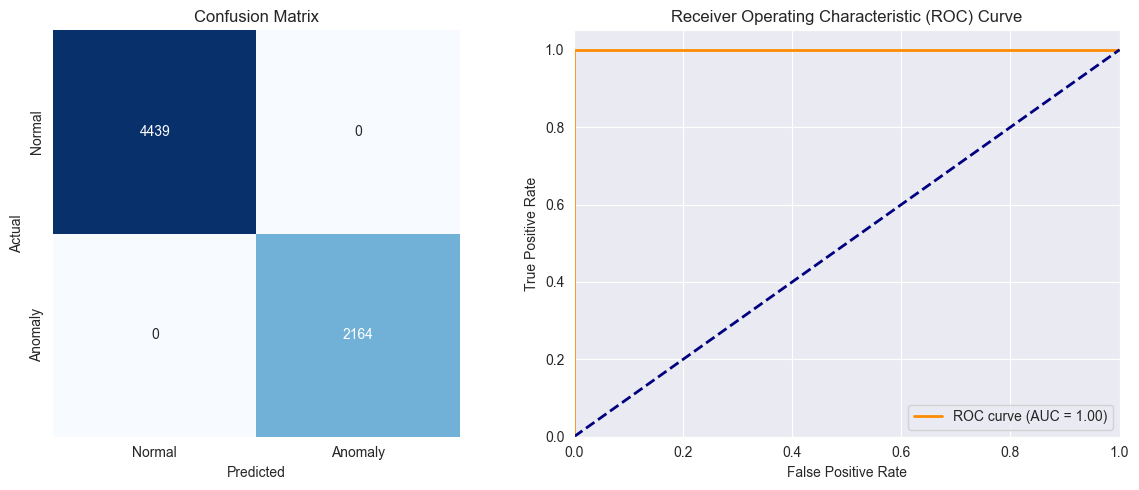

In [41]:
# Drop rows with NaN values in 'Class' column to retain only true anomalies
data = pd.concat([trainingData, testingData])
data = data.dropna(subset=['Class'])

# Calculate Z-scores
scaler = StandardScaler()
data['z_score'] = scaler.fit_transform(data['Measure'].values.reshape(-1, 1))

# Set the upper and lower threshold based on the best threshold found earlier
best_threshold = 1.0  # Replace with the actual best threshold value

# Label anomalies based on the upper and lower thresholds
data['is_anomaly'] = (data['z_score'] > best_threshold) | (data['z_score'] < -best_threshold)

# Split the data into features and target
X = data['z_score'].values.reshape(-1, 1)  # Features (Z-scores)
y = data['is_anomaly'].astype(int)  # Target (0 for normal, 1 for anomaly)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier (you can use other classifiers as well)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_test = clf.predict(X_test)
display(y_pred_test)
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Calculate classification metrics (accuracy, precision, recall, F1-score)
classification_metrics = classification_report(y_test, y_pred_test, target_names=['Normal', 'Anomaly'])

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Print classification metrics
print("Classification Metrics:")
print(classification_metrics)

plt.tight_layout()
plt.show()